<a href="https://colab.research.google.com/github/feliciahf/data_science_exam/blob/main/hippocorpus_binaryclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset

In [17]:
# import csv file as dataframe (from GitHub repo)
url = 'https://raw.githubusercontent.com/feliciahf/data_science_exam/main/hippoCorpusV2.csv'
df = pd.read_csv(url, encoding='latin1')
df_full = pd.read_csv(url, encoding='latin1') # for visualisation

# Clean data

In [18]:
# Are there missing values in the train set?
df.isnull().sum()

AssignmentId            0
WorkTimeInSeconds       0
WorkerId                0
annotatorAge           23
annotatorGender         0
annotatorRace           0
distracted              0
draining                0
frequency            2756
importance            144
logTimeSinceEvent       0
mainEvent               0
memType                 0
mostSurprising          0
openness                0
recAgnPairId         4235
recImgPairId         1526
similarity           4098
similarityReason     4098
story                   0
stressful               0
summary                 0
timeSinceEvent          0
dtype: int64

In [19]:
# Okay, lots of missing values. Filling them with the mean value of the column
df["annotatorAge"] = df["annotatorAge"].fillna(df["annotatorAge"].mean())
df["frequency"] = df["frequency"].fillna(df["frequency"].mean())
df["importance"] = df["importance"].fillna(df["importance"].mean())
df["similarity"] = df["similarity"].fillna(df["similarity"].mean())

In [20]:
# Let's see if it worked
df.isnull().sum()

AssignmentId            0
WorkTimeInSeconds       0
WorkerId                0
annotatorAge            0
annotatorGender         0
annotatorRace           0
distracted              0
draining                0
frequency               0
importance              0
logTimeSinceEvent       0
mainEvent               0
memType                 0
mostSurprising          0
openness                0
recAgnPairId         4235
recImgPairId         1526
similarity              0
similarityReason     4098
story                   0
stressful               0
summary                 0
timeSinceEvent          0
dtype: int64

In [21]:
# sklearn does not like columns with categorical values
# make them binary dummy variables instead
df = pd.get_dummies(df, columns=["annotatorGender", "annotatorRace"])

In [32]:
# drop retold label
df = df[df.memType != 'retold']
df_full = df_full[df_full.memType != 'retold']

In [23]:
# make labels column using numerical values
df.memType = pd.Categorical(df.memType)
df['label'] = df.memType.cat.codes

# story type corresponding to label
print(f"Label 0: {df.loc[df['label'] == 0,'memType'].unique()}")
print(f"Label 1: {df.loc[df['label'] == 1,'memType'].unique()}")

Label 0: ['imagined']
Categories (1, object): ['imagined']
Label 1: ['recalled']
Categories (1, object): ['recalled']


In [24]:
# drop categorical column
df = df.drop(columns='memType')

In [25]:
# AssignmentId, WorkerId, recAgnPairId and recImgPairId are practically unique for each individual and thus unusable for predictions
# mainEvent, mostSurprising, similarityReason, story and summary contain text and are unique to each individual
uninformative_cols = ["AssignmentId", "WorkerId", "recAgnPairId", "recImgPairId"]
text_cols = ["mainEvent", "mostSurprising", "similarityReason", "story", "summary"]
df = df.drop(columns=uninformative_cols)
df = df.drop(columns=text_cols)

In [26]:
# age as binary measures
df['Old'] = np.where(df['annotatorAge']>=44, 1, 0)
df['Young'] = np.where(df['annotatorAge']>=25, 0, 1)
df['Middle1'] = np.where((df['annotatorAge']>=33) & (df['annotatorAge'] >=25), 1, 0)
df['Middle2'] = np.where((df['annotatorAge']>=44) & (df['annotatorAge'] >=33), 1, 0)

In [ ]:
# drop columns made into binary measures ? (better with both binary and continuous variables)
#newbin_cols = ["annotatorAge"]
#df = df.drop(columns=newbin_cols)

In [27]:
# drop race columns
# variable doesn't make much difference kept/dropped
race = ["annotatorRace_asian", "annotatorRace_black", "annotatorRace_hisp", "annotatorRace_indian", "annotatorRace_islander", "annotatorRace_middleEastern", "annotatorRace_na", "annotatorRace_native", "annotatorRace_other", "annotatorRace_white"]
df = df.drop(columns=race)

# Inspect data visually

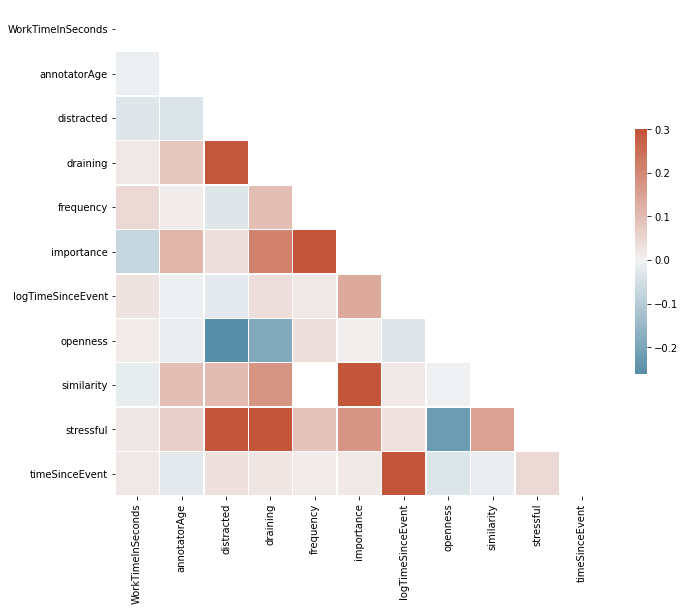

In [33]:
# Compute the correlation matrix
corr = df_full.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

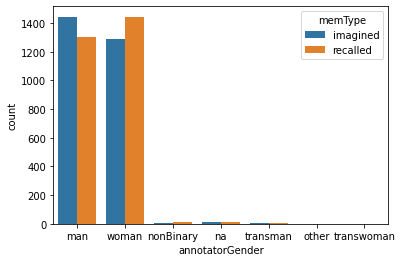

In [34]:
# histogram of gender and story type
sns.countplot(x="annotatorGender", hue="memType", data=df_full)

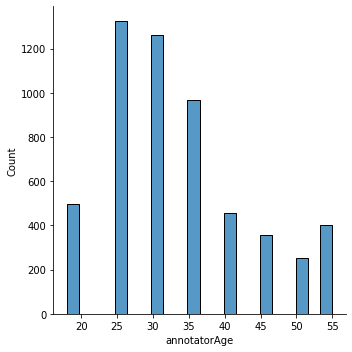

In [35]:
# age distribution
sns.displot(df_full, x="annotatorAge")

[Text(0.5, 0, 'annotatorGender')]

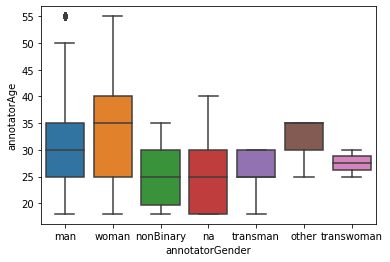

In [36]:
# Boxplot of age and sex
ax = sns.boxplot(x="annotatorGender", y="annotatorAge", data=df_full)
ax.set(xlabel="annotatorGender")

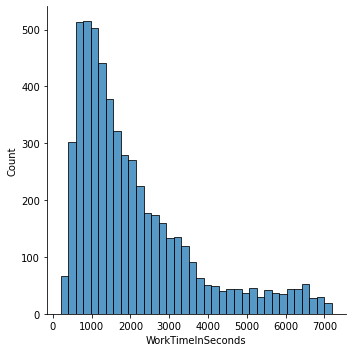

In [37]:
# WorkTimeInSeconds distribution
sns.displot(df_full, x="WorkTimeInSeconds")

# Split into testing and training data

In [38]:
# split df into test and train
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

# Logistic Regression model

In [39]:
# Creating a good old logistic regression model based on the remaining columns
model = LogisticRegression()
# Make subset of training data containing everything except the label
X = train.loc[:, train.columns != "label"]
# Make subset containing only the label
Y = train["label"]

# Fit model on training data
model.fit(X, Y)
# See how well the model does on the training data
yhat = model.predict(X)

print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

Accuracy on train data: 0.49587155963302754


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[2162,    0],
       [2198,    0]])

In [40]:
# Test the model on the testing set
X_test = test.loc[:, train.columns != "label"]
Y_test = test["label"]

yhat_test = model.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)

Accuracy on test data: 0.505531914893617


array([[594,   0],
       [581,   0]])

In [41]:
print(classification_report(Y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       594
           1       0.00      0.00      0.00       581

    accuracy                           0.51      1175
   macro avg       0.25      0.50      0.34      1175
weighted avg       0.26      0.51      0.34      1175



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Ridge classifier

In [42]:
# Regularisation: Ridge classifier
model_rid = RidgeClassifier()

# Fit model on training data
model_rid.fit(X, Y)

# See how well the model does on the training data
yhat = model_rid.predict(X)

print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

# Test the model on the testing set
X_test = test.loc[:, train.columns != "label"]
Y_test = test["label"]

yhat_test = model_rid.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)

Accuracy on train data: 0.8075688073394496
Accuracy on test data: 0.8008510638297872


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.06792e-120): result may not be accurate.
  overwrite_a=True).T


array([[455, 139],
       [ 95, 486]])

In [43]:
# Cross-validation - 10fold
scores_rid = cross_val_score(model_rid, X, Y, cv=10)
print('Cross-Validation Accuracy Scores', scores_rid)

scores_rid = pd.Series(scores_rid)
scores_rid.min(), scores_rid.mean(), scores_rid.max()

Cross-Validation Accuracy Scores [0.78899083 0.82110092 0.81192661 0.80504587 0.80963303 0.82798165
 0.80275229 0.80733945 0.80045872 0.78899083]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.06706e-119): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.4257e-120): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.06987e-120): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.06783e-120): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.06774e-120): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: L

(0.7889908256880734, 0.806422018348624, 0.8279816513761468)

In [44]:
print(classification_report(Y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       594
           1       0.78      0.84      0.81       581

    accuracy                           0.80      1175
   macro avg       0.80      0.80      0.80      1175
weighted avg       0.80      0.80      0.80      1175

